In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import triangle
import matplotlib.pyplot as plt
from lm import LM
import scipy as sp
jnp.set_printoptions(precision=4,linewidth=120)


In [79]:
Nside=8
Nsquare=Nside*4
v=np.linspace(0,1,Nside,endpoint=False)
z=np.zeros(Nside)
o=np.ones(Nside)
square=np.c_[np.r_[v,o,1-v,z],np.r_[z,v,o,1-v]]
square_seg = np.c_[np.arange(square.shape[0]-1),np.arange(1,square.shape[0])]
square_seg = np.r_[square_seg,np.array([[square.shape[0]-1,0]])]

Ncircle = 36
r=0.2
cx,cy=0.35,0.5
theta = np.linspace(0, 2 * np.pi, Ncircle, endpoint=False)
circle = np.stack([r*np.cos(theta)+cx, r*np.sin(theta)+cy], axis=1)
circle_seg = np.c_[np.arange(circle.shape[0]-1), np.arange(1,circle.shape[0])]
circle_seg = np.r_[circle_seg,np.array([[circle.shape[0]-1,0]])]
circle_seg+=square.shape[0]
Nspecified=Nsquare+Ncircle
specified=np.arange(Nspecified)

In [80]:
A = dict(vertices=np.r_[square,circle], segments=np.r_[square_seg,circle_seg], holes=[[cx, cy]])
B = triangle.triangulate(A, 'qpa0.001D')



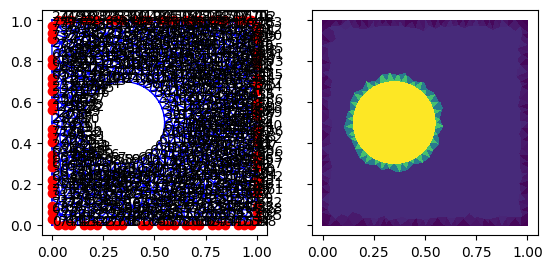

In [91]:
vmarks = B['vertex_markers']
boundary = np.where(vmarks==1)[0]
inserted_boundary_idx = boundary[boundary + 1 > Nspecified]
tr=B['triangles']
verts = B['vertices']
Nv = verts.shape[0]
interior = np.setdiff1d(np.arange(Nv), boundary)
f=np.zeros(Nv)
f[:Nsquare]=1.
f[Nsquare:Nsquare + Ncircle]=10.
f[interior]=1.5
fig1, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'b-',triangles=tr,lw=1)
_=ax[0].plot(verts[inserted_boundary_idx,0],verts[inserted_boundary_idx,1],'ro')
[ax[0].annotate(f'{i}', (verts[i,0], verts[i,1])) for i in range(Nv)]
ax[1].set_aspect('equal')
_=ax[1].tripcolor(verts[:,0],verts[:,1],f)

In [92]:
def get_neighbors(i):
    return np.setdiff1d(np.unique(np.ravel(tr[np.where(tr==i)[0]])),i)

def interpolate_inserted_boundary(inserted, specified):
    d = np.sqrt(np.sum((verts[inserted,None]-verts[None,specified])**2, axis=-1))
    sorted_idx = np.argsort(d,axis=1)[:,:2]
    d2=np.take_along_axis(d,sorted_idx, axis=1)
    w = d2/np.sum(d2,axis=1)[:,None]
    return np.sum(np.take(f,sorted_idx) * w, axis=1)


def get_five_neighbors(i):
    nb=get_neighbors(i)
    boundary_nb = np.intersect1d(nb, boundary)
    if boundary_nb.size > 2:
        d=np.sum((verts[i]-verts[boundary_nb])**2,axis=1)
        boundary_nb_idx = np.argsort(d)
        if np.in1d(i, boundary):  # if boundary element, allow 2 closest boundary neighbors.
            boundary_nb=boundary_nb_idx[:2]
        else: #if interior element, allow 2 furthest boundary neighbors
            boundary_nb=boundary_nb_idx[-2:]
        
        nb = np.union1d(boundary_nb, np.setdiff1d(nb, boundary))
    if nb.size<5:
        for ii in nb:
            nb=np.union1d(nb, get_neighbors(ii))
        nb=np.setdiff1d(nb,i)
        boundary_nb = np.intersect1d(nb, boundary)
        if boundary_nb.size > 2:
            d=np.sum((verts[i]-verts[boundary_nb])**2,axis=1)
            boundary_nb_idx = np.argsort(d)
            if np.in1d(i, boundary):  # if boundary element, allow 2 closest boundary neighbors.
                boundary_nb=boundary_nb_idx[:2]
            else: #if interior element, allow 2 furthest boundary neighbors
                boundary_nb=boundary_nb_idx[-2:]
            
            nb = np.union1d(boundary_nb, np.setdiff1d(nb, boundary))
    if nb.size>5:
        d=np.sum((verts[i]-verts[nb])**2,axis=1)
        return nb[np.argpartition(d,5)[:5]]
    else:
        return nb

In [93]:
f[inserted_boundary_idx]=interpolate_inserted_boundary(inserted_boundary_idx, specified)
f=jnp.asarray(f)
f[inserted_boundary_idx]


Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float64)

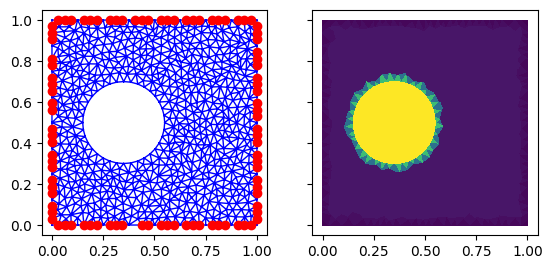

In [94]:
fig1, ax = plt.subplots(1,2, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'b-',triangles=tr,lw=1)
_=ax[0].plot(verts[inserted_boundary_idx,0],verts[inserted_boundary_idx,1],'ro')
ax[1].set_aspect('equal')
_=ax[1].tripcolor(verts[:,0],verts[:,1],f)

In [95]:
# f = a1*x^2 + a2*y^2 + a3*x + a4*y + a5*xy + f0
# df/dx = 2a1*x + a3 + a5*y
# df/dy = 2a2*y + a4 + a5*x
# df2/dx2 = 2a1
# df2/dy2 = 2a2
#df2/dxdy = a5

def get_LU(i):
    n5 = get_five_neighbors(i)
    x,y = (verts[n5]-verts[i]).T
    return jax.scipy.linalg.lu_factor(np.c_[x**2, y**2, x, y, x*y]),n5

def get_LUs(interior):
    LUs=[]
    pivs=[]
    n5s=[]
    for i in interior:
        (LU, piv), n5 = get_LU(i)
        LUs.append(LU)
        pivs.append(piv)
        n5s.append(n5)
    n5s=jnp.stack(n5s)
    LUs=jnp.stack(LUs)
    pivs=jnp.stack(pivs)
    return LUs, pivs, n5s

LUs, pivs, n5s=get_LUs(interior)
lu_solve_vec=jax.vmap(jax.scipy.linalg.lu_solve,in_axes=((0,0),0))
@jax.jit
def get_coeffs(f):
    return lu_solve_vec((LUs, pivs), jnp.take(f,n5s)-f[interior,None])

In [96]:
@jax.jit
def eqs(f_interior, f=f):
    f=f.at[interior].set(f_interior)
    a=get_coeffs(f)
    return 2*jnp.sum(a[:,:2],axis=1)
    

In [97]:
solver=LM(eqs, f[interior])
res = solver(L=1, rho_tol = 0.1, maxiter=100, xtol=1e-12, ftol=1e-15,iter_print=25)
sol = f.at[interior].set(res.x)

Levenberg-Marquadrt Jacobian shape: (605, 605)
Iteration: 10  L: 2.87e-10
f abs mean: 1.15e-12  max: 8.84e-12


In [98]:
sol[boundary]

Array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float64)

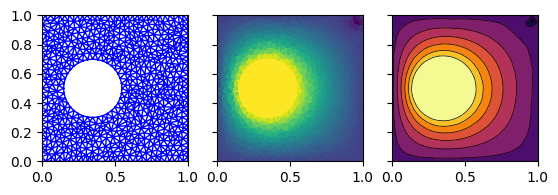

In [99]:
gridx, gridy = np.mgrid[0:1:100j, 0:1:100j]
gridz=sp.interpolate.griddata(verts, sol, (gridx, gridy), method='linear')
fig2, ax = plt.subplots(1,3, sharex=True, sharey=True)
ax[0].set_aspect('equal')
_=ax[0].triplot(verts[:,0],verts[:,1],'b-',triangles=tr,lw=1)
ax[1].set_aspect('equal')
_=ax[1].tripcolor(verts[:,0],verts[:,1],sol)
ax[2].set_aspect('equal')
_=ax[2].contour(gridx, gridy, gridz, 8, linewidths=0.5, colors='k')
_=ax[2].contourf(gridx, gridy, gridz, 8, vmax=np.max(gridz), vmin=np.min(gridz), cmap='inferno')

In [100]:
sol[interior]

Array([ 4.7213,  6.2726,  5.6605,  5.1463,  5.1028,  5.9625,  6.3159,  6.5063,  6.8497,  7.0512,  6.6935,  6.7644,
        7.6266,  7.465 ,  7.6908,  6.721 ,  7.5554,  7.4508,  7.1541,  7.4664,  8.0554,  6.4644,  7.7937,  8.272 ,
        6.9325,  8.0525,  8.0722,  7.7663,  7.8955,  8.8596,  8.7806,  8.6301,  8.7827,  8.9358,  8.2924,  9.06  ,
        9.0768,  8.9276,  8.9847,  8.0487,  7.8132,  8.0196,  7.8431,  7.4756,  7.996 ,  8.2357,  8.4205,  8.3534,
        8.4085,  8.079 ,  8.2915,  8.2237,  8.1389,  6.2296,  8.19  ,  6.7047,  4.1844,  5.1563,  4.6901,  6.3239,
        7.0759,  4.4081,  5.5531,  6.2609,  7.459 ,  6.5931,  7.5784,  7.5332,  5.3636,  6.3166,  7.2704,  6.5047,
        7.2723,  5.96  ,  6.1114,  5.1927,  7.2169,  7.4691,  6.695 ,  6.1714,  8.0625,  7.0433,  5.5106,  6.3552,
        7.1139,  5.6772,  6.8941,  5.5362,  6.5369,  6.7469,  7.6905,  5.9359,  6.6806,  4.7065,  5.7664,  6.4026,
        7.6826,  8.6101,  6.7977,  7.7152,  7.2952,  6.9695,  6.6117,  7.2926,  